In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os, sys
import scipy.integrate as spi
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from tqdm import tqdm

CURRENT_DIR = os.getcwd()
module_path = os.path.abspath(os.path.join(CURRENT_DIR, "../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
from Anydim_transferability.DeepSet.model import DeepSet
from Anydim_transferability.O_d.model import ScalarModel, ScalarModel_KMeans
from Anydim_transferability.O_d import color_dict
from Anydim_transferability import typesetting

typesetting()

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def preprocess(model_name, X):
    if model_name == "SVD-DS (Normalized)" or model_name == "SVD-DS":
        S = torch.matmul(X.transpose(1, 2), X)  # num_pointclouds x 3 x 3
        U, D, _ = torch.svd(S)  # num_pointclouds x 3 x 3
        S = torch.matmul(X, U)  # num_pointclouds x num_points x 3
        return S
    elif model_name == "DS-CI (Normalized)" or model_name == "DS-CI (Compatible)":
        num_pointclouds = X.shape[0]
        n = X.shape[1]
        data = Data()
        Gram = torch.FloatTensor(torch.matmul(X, X.transpose(1, 2)))  # num_pointclouds x n x n

        data.f_d = torch.diagonal(Gram, 0, dim1=1, dim2=2).unsqueeze(-1)  # num_pointclouds x n x 1
        if model_name == "DS-CI (Normalized)":
            off_mask = torch.triu(torch.ones(n, n), diagonal=1) == 1
            data.f_o = Gram[:, off_mask].unsqueeze(-1)  # num_pointclouds x n(n-1)/2 x 1
            data.f_star = ((data.f_d * (Gram.sum(dim=2, keepdim=True) - data.f_d)).sum(dim=1)) / (
                n * (n - 1)
            )  # num_pointclouds x 1
        elif model_name == "DS-CI (Compatible)":
            data.f_o = Gram.reshape(num_pointclouds, -1).unsqueeze(
                -1
            )  # num_pointclouds x (n^2) x 1
            data.f_star = ((data.f_d * (Gram.sum(dim=2, keepdim=True))).sum(dim=1)) / (n * n)

        return data
    elif model_name == "OI-DS (Normalized)":
        num_pointclouds = X.shape[0]
        n = X.shape[1]
        K_all = np.zeros((num_pointclouds, 3, 3))
        data = Data()
        for i in range(num_pointclouds):
            kmeans = KMeans(n_clusters=3, random_state=0, init="k-means++", n_init=20).fit(X[i])
            K = kmeans.cluster_centers_  # (num_centroids, 3)
            # sort Kmeans centroid by norm
            indexlist = np.argsort(np.linalg.norm(K, axis=1))
            K = K[indexlist, :]
            K_all[i] = K
        K_all = torch.FloatTensor(K_all)
        data.f_o = torch.matmul(X, K_all.transpose(1, 2))  # num_pointclouds x n x k
        Gram_k = torch.matmul(K_all, K_all.transpose(1, 2))  # num_pointclouds x k x k
        data.f_d = Gram_k.reshape(num_pointclouds, 3 * 3)  # num_pointclouds x k^2
        return data

In [4]:
n_samples = 100
log_n_range = np.arange(1, 3.5, 0.4)

# fix input distribution
gaussian = torch.distributions.Normal(loc=0.0, scale=1.0)
torch.manual_seed(0)
# fix 4 models with random weights
params = {
    "hid_dim": 16,
    "out_dim": 1,
}
params["model_name"] = "SVD-DS (Normalized)"
svdds = DeepSet(
    in_channels=3,
    out_channels=params["out_dim"],
    hidden_channels=params["hid_dim"],
    set_channels=params["hid_dim"] * 2,
    feature_extractor_num_layers=3,
    regressor_num_layers=2,
    normalization="sum",
)
svdds.eval()
params["model_name"] = "SVD-DS (Normalized)"
svdds_normalized = DeepSet(
    in_channels=3,
    out_channels=params["out_dim"],
    hidden_channels=params["hid_dim"],
    set_channels=params["hid_dim"] * 2,
    feature_extractor_num_layers=3,
    regressor_num_layers=2,
    normalization="mean",
)
svdds_normalized.eval()
params["model_name"] = "DS-CI (Compatible)"
dsci = ScalarModel(**params)
dsci.eval()
params["model_name"] = "OI-DS (Normalized)"
oidsi = ScalarModel_KMeans(**params)
oidsi.eval()

# compute output
n_range = np.power(10, log_n_range).astype(int)
models = {
    "SVD-DS": svdds,
    "SVD-DS (Normalized)": svdds_normalized,
    "DS-CI (Normalized)": dsci,
    "DS-CI (Compatible)": dsci,
    "OI-DS (Normalized)": oidsi,
}
outputs = {}
for model_name, model in models.items():
    print(f"Computing outputs for {model_name}")
    outputs.setdefault(model_name, [])
    for i, n in tqdm(enumerate(n_range)):
        X = gaussian.sample((n_samples * 3, n)).unsqueeze(-1)
        X = X.reshape(n_samples, 3, n).transpose(1, 2)

        X = preprocess(X=X, model_name=model_name)
        with torch.no_grad():
            output = model(X)
            outputs[model_name].append(output)

Computing outputs for SVD-DS


7it [00:00, 215.61it/s]


Computing outputs for SVD-DS (Normalized)


7it [00:00, 329.82it/s]


Computing outputs for DS-CI (Normalized)


7it [00:13,  1.95s/it]


Computing outputs for DS-CI (Compatible)


7it [00:26,  3.82s/it]


Computing outputs for OI-DS (Normalized)


7it [00:41,  5.92s/it]


In [9]:
limits = {}


def deepset_limit(model):
    def integrand(x, y, z):
        with torch.no_grad():
            input_tensor = torch.Tensor([x, y, z]).reshape(1, 1, 3)
            output = model.feature_extractor(input_tensor).squeeze().detach().numpy()
        pdf = np.exp(-(x**2 + y**2 + z**2) / 2) / ((2 * np.pi) ** 1.5)
        return output * pdf

    # Integrate each component of the vector separately
    result = []
    for i in range(50):  # multi-dimensional integration over the set-channel=50
        component_integrand = lambda x, y, z: integrand(x, y, z)[i]
        integral, _ = spi.tplquad(
            component_integrand,
            -np.inf,
            np.inf,
            lambda x: -np.inf,
            lambda x: np.inf,
            lambda x, y: -np.inf,
            lambda x, y: np.inf,
        )
        result.append(integral)
    result = np.array(result)

    return float(model.regressor(torch.Tensor(result).reshape(1, 1, -1)))


limits["SVD-DS (Normalized)"] = deepset_limit(svdds_normalized)

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/cis/home/yma93/miniconda3/envs/m

KeyboardInterrupt: 

Computing outputs for SVD-DS


7it [00:00, 202.86it/s]


Computing outputs for SVD-DS (Normalized)


7it [00:00, 294.46it/s]


Computing outputs for DS-CI (Normalized)


0it [00:00, ?it/s]

7it [00:14,  2.00s/it]


Computing outputs for DS-CI (Compatible)


7it [00:27,  3.88s/it]


Computing outputs for OI-DS (Normalized)


7it [00:41,  5.89s/it]


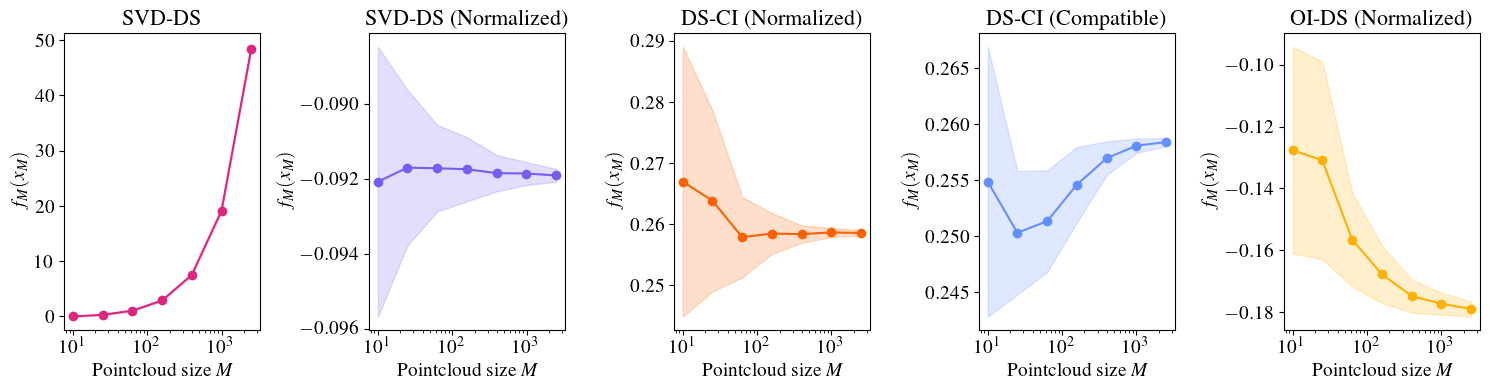

In [ ]:
# plot
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
for ax, model_name in zip(axs, models.keys()):
    # ax.errorbar(
    #     n_range,
    #     [float(outputs[model_name][i].mean(dim=0).squeeze()) for i in range(len(n_range))],
    #     [float(outputs[model_name][i].std(dim=0).squeeze()) for i in range(len(n_range))],
    #     fmt="o",
    #     capsize=3,
    #     markersize=5,
    #     color=color_dict[model_name],
    # )
    ax.plot(
        n_range,
        [float(outputs[model_name][i].mean(dim=0).squeeze()) for i in range(len(n_range))],
        "o-",
        color=color_dict[model_name],
    )
    ax.fill_between(
        n_range,
        [
            float(outputs[model_name][i].mean(dim=0).squeeze())
            - float(outputs[model_name][i].std(dim=0).squeeze())
            for i in range(len(n_range))
        ],
        [
            float(outputs[model_name][i].mean(dim=0).squeeze())
            + float(outputs[model_name][i].std(dim=0).squeeze())
            for i in range(len(n_range))
        ],
        color=color_dict[model_name],
        alpha=0.2,
    )
    if model_name in limits:
        ax.axhline(limits[model_name], color="black", linestyle="--", label="Limit")
    ax.set_xscale("log")
    ax.set_xlabel("Pointcloud size $M$", fontsize=14)
    ax.set_ylabel("$f_M(x_M)$", fontsize=14)
    ax.set_title(model_name, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=14)

plt.tight_layout()
plt.savefig(CURRENT_DIR + "/log/transferability/O(d)_transferability_outputs.pdf")
plt.show()

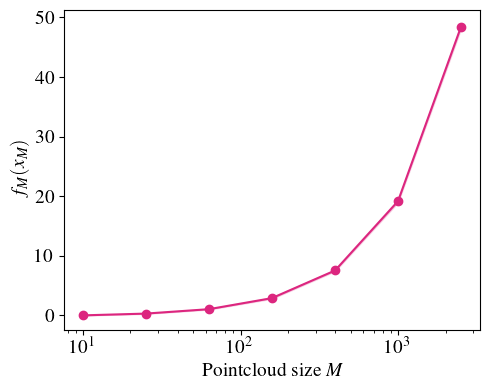

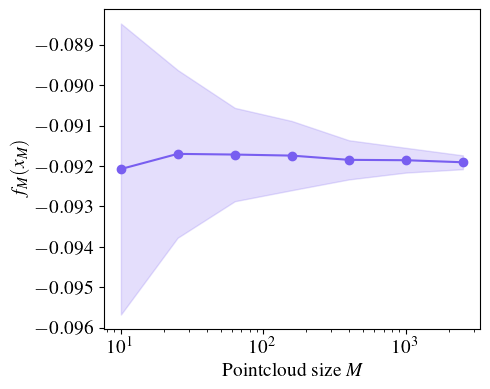

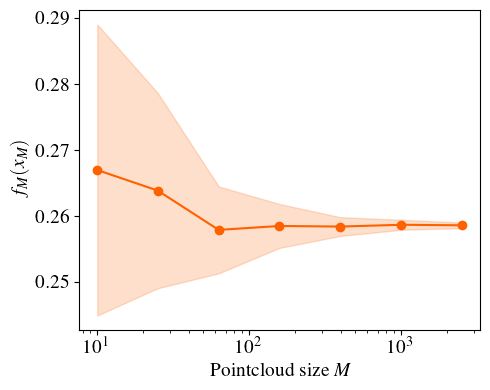

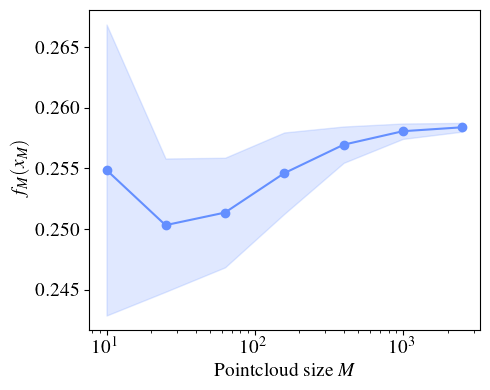

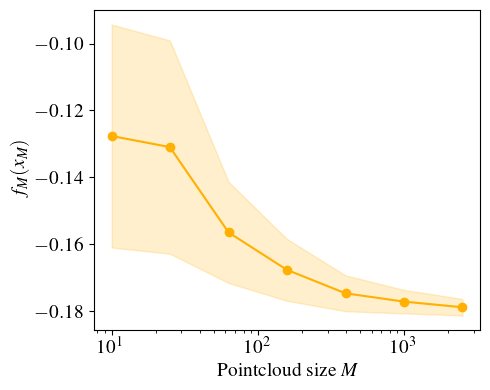

In [4]:
# plot
for model_name in models.keys():
    plt.figure(figsize=(5, 4))
    plt.plot(
        n_range,
        [float(outputs[model_name][i].mean(dim=0).squeeze()) for i in range(len(n_range))],
        "o-",
        color=color_dict[model_name],
    )
    plt.fill_between(
        n_range,
        [
            float(outputs[model_name][i].mean(dim=0).squeeze())
            - float(outputs[model_name][i].std(dim=0).squeeze())
            for i in range(len(n_range))
        ],
        [
            float(outputs[model_name][i].mean(dim=0).squeeze())
            + float(outputs[model_name][i].std(dim=0).squeeze())
            for i in range(len(n_range))
        ],
        color=color_dict[model_name],
        alpha=0.2,
    )
    plt.xscale("log")
    plt.xlabel("Pointcloud size $M$", fontsize=14)
    plt.ylabel("$f_M(x_M)$", fontsize=14)
    plt.tick_params(axis="both", which="major", labelsize=14)
    plt.tight_layout()
    plt.savefig(
        CURRENT_DIR
        + f"/log/transferability/{model_name.lower().replace(' ', '_')}_transferability_outputs.pdf"
    )
    plt.show()

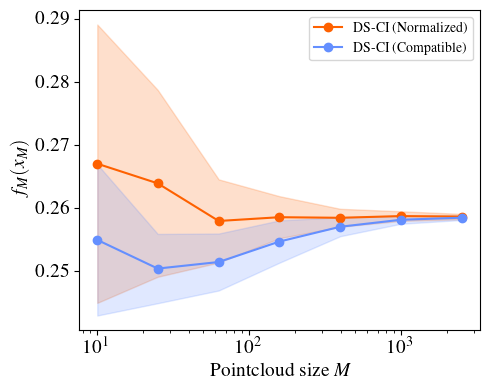

In [5]:
fig, axs = plt.subplots(figsize=(5, 4))

for model_name in ["DS-CI (Normalized)", "DS-CI (Compatible)"]:
    axs.plot(
        n_range,
        [float(outputs[model_name][i].mean(dim=0).squeeze()) for i in range(len(n_range))],
        "o-",
        color=color_dict[model_name],
        label=model_name,
    )
    axs.fill_between(
        n_range,
        [
            float(outputs[model_name][i].mean(dim=0).squeeze())
            - float(outputs[model_name][i].std(dim=0).squeeze())
            for i in range(len(n_range))
        ],
        [
            float(outputs[model_name][i].mean(dim=0).squeeze())
            + float(outputs[model_name][i].std(dim=0).squeeze())
            for i in range(len(n_range))
        ],
        color=color_dict[model_name],
        alpha=0.2,
    )

axs.set_xscale("log")
axs.set_xlabel("Pointcloud size $M$", fontsize=14)
axs.set_ylabel("$f_M(x_M)$", fontsize=14)
axs.tick_params(axis="both", which="major", labelsize=14)
axs.legend()

plt.tight_layout()
plt.savefig(CURRENT_DIR + "/log/transferability/dsci_comparison_outputs.pdf")
plt.show()

/tmp/ipykernel_3700123/2435513278.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(all_outputs.min(), all_outputs.max())


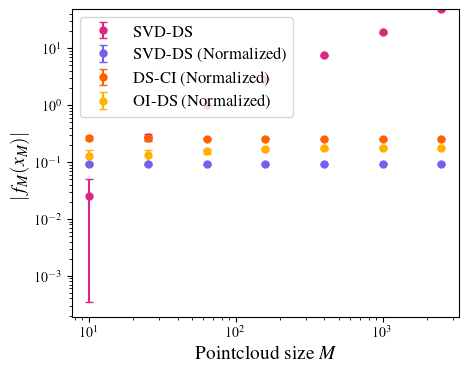

In [6]:
# plot
fig, ax = plt.subplots(figsize=(5, 4))
models_plot = ["SVD-DS", "SVD-DS (Normalized)", "DS-CI (Normalized)", "OI-DS (Normalized)"]
for model_name in models_plot:
    ax.errorbar(
        n_range,
        [abs(float(outputs[model_name][i].mean(dim=0).squeeze())) for i in range(len(n_range))],
        [abs(float(outputs[model_name][i].std(dim=0).squeeze())) for i in range(len(n_range))],
        fmt="o",
        capsize=3,
        markersize=5,
        color=color_dict[model_name],
        label=model_name,
    )
all_outputs = torch.stack([torch.stack(outputs[model]) for model in models.keys()])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Pointcloud size $M$", fontsize=14)
ax.set_ylabel("$|f_M(x_M)|$", fontsize=14)
ax.legend(fontsize=12, loc="upper left")
plt.ylim(all_outputs.min(), all_outputs.max())

plt.savefig(CURRENT_DIR + "/log/transferability/O(d)_transferability_outputs_combined.pdf")
plt.show()

# Check compatibility

In [10]:
gaussian = torch.distributions.Normal(loc=0.0, scale=1.0)
# compute output
n_range = np.power(10, log_n_range).astype(int)
models = {
    "SVD-DS": svdds,
    "SVD-DS (Normalized)": svdds_normalized,
    "DS-CI (Normalized)": dsci,
    "DS-CI (Compatible)": dsci,
    "OI-DS (Normalized)": oidsi,
}
n = 100
outputs = {}
for model_name, model in models.items():
    print(f"Computing outputs for {model_name}")
    outputs.setdefault(model_name, [])
    X = gaussian.sample((1 * 3, n)).unsqueeze(-1)
    X = X.reshape(1, 3, n).transpose(1, 2)
    X_large = X.repeat(1, 2, 1)
    X = preprocess(X=X, model_name=model_name)
    X_large = preprocess(X=X_large, model_name=model_name)

    with torch.no_grad():
        output = model(X)
        output_large = model(X_large)
    print(output, output_large)

Computing outputs for SVD-DS
tensor([[1.7619]]) tensor([[3.7570]])
Computing outputs for SVD-DS (Normalized)
tensor([[-0.0922]]) tensor([[-0.0922]])
Computing outputs for DS-CI (Normalized)
tensor([[0.2591]]) tensor([[0.2556]])
Computing outputs for DS-CI (Compatible)
tensor([[0.2473]]) tensor([[0.2473]])
Computing outputs for OI-DS (Normalized)
tensor([[-0.1567]]) tensor([[-0.1549]])
